In [1]:
%matplotlib inline
import cv2
import numpy as np
from matplotlib import pyplot as plt
import helpers
import pandas as pd
from skimage import exposure
from PIL import Image
from scipy import ndimage
from skimage.measure import label, regionprops_table, regionprops

In [2]:
filename = 'benoitdata/F20-14A/HA-900_6um_jamtveit_att_pag-2.29_3.40_02043.tif'

img = cv2.imread(filename,0)

(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:>)

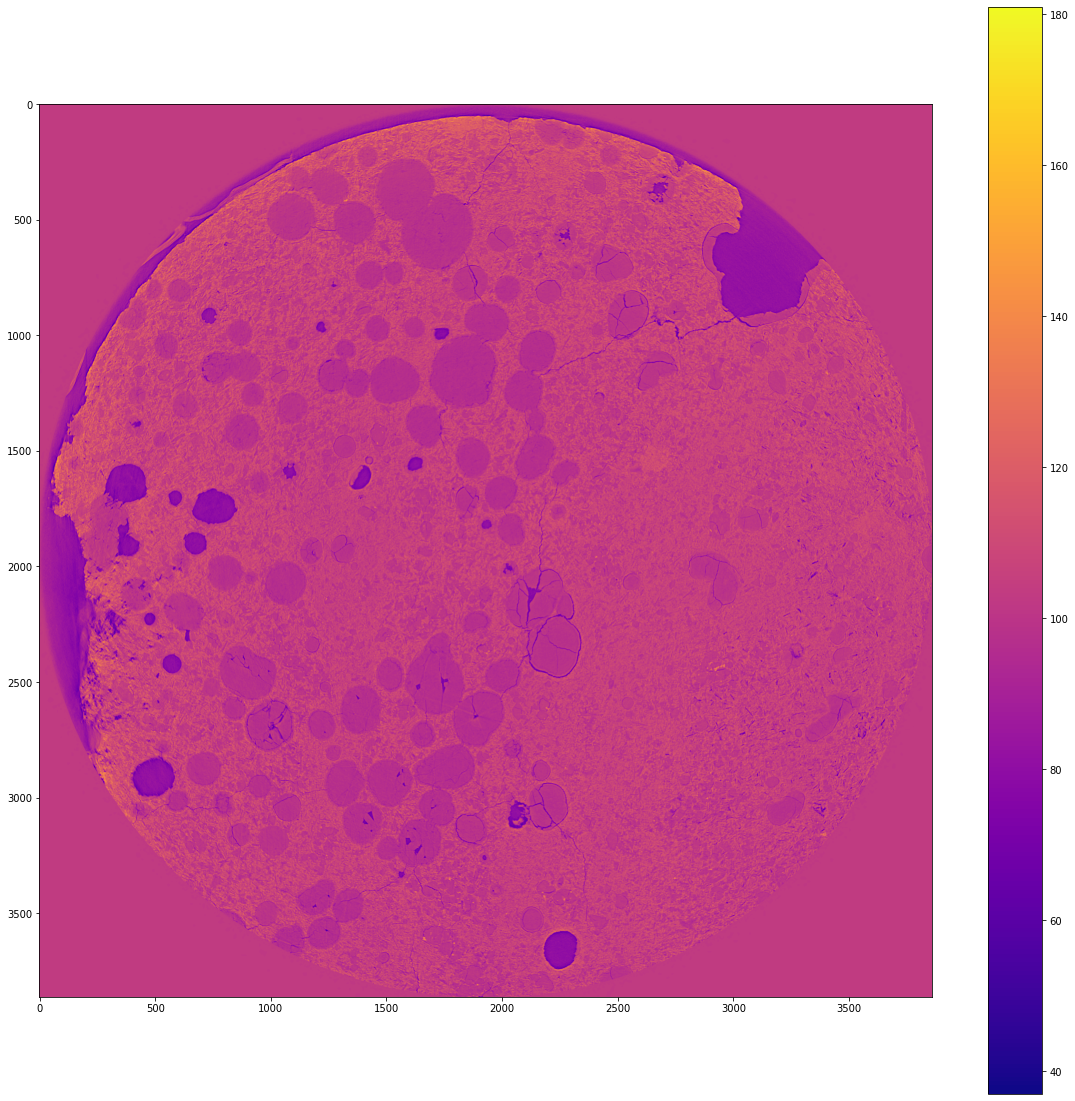

In [3]:
helpers.plot_image(img)

In [4]:
# dst = cv2.cornerHarris(img,2,3,0.04)
# dst = cv2.dilate(dst,None)
# # helpers.plot_image(dst)
# plt.hist(dst, bins=100)

kernel = np.ones((3,3),np.uint8)

ret, thresh = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)


# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0

markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]

error: OpenCV(4.5.1) /tmp/pip-req-build-7m_g9lbm/opencv/modules/imgproc/src/segmentation.cpp:161: error: (-215:Assertion failed) src.type() == CV_8UC3 && dst.type() == CV_32SC1 in function 'watershed'


1.945352890703836e-06
3.787689823659703


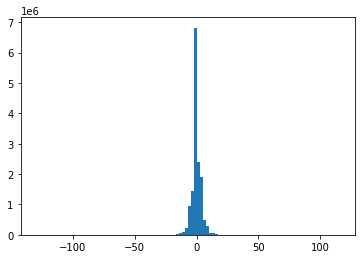

In [11]:
plt.hist(laplacian.ravel(), bins=100)
print(np.mean(laplacian.ravel()))
print(np.std(laplacian.ravel()))

(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:>)

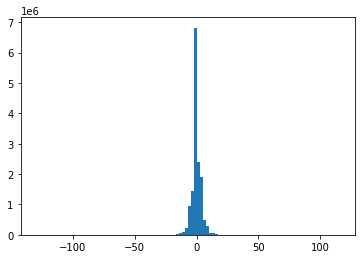

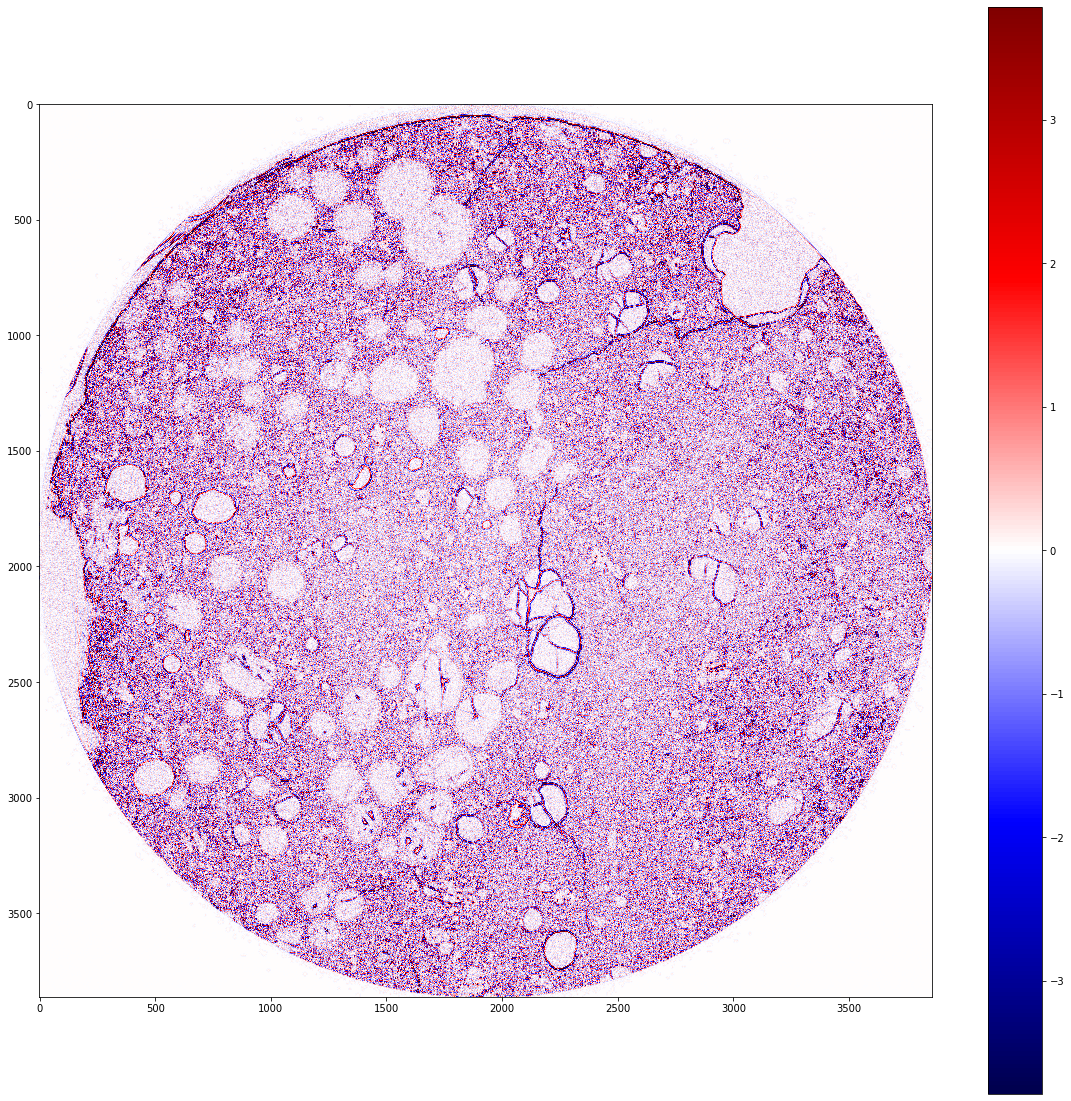

In [33]:
i = img.copy()
# i = cv2.GaussianBlur(i,(5,5),0)

laplacian = cv2.Laplacian(i,cv2.CV_64F)
sobelx = cv2.Sobel(i,cv2.CV_64F,1,0,ksize=5)
sobely = cv2.Sobel(i,cv2.CV_64F,0,1,ksize=5)

i = laplacian.copy()
# i = sobelx.copy()
# i = sobely.copy()

plt.hist(i.ravel(), bins=100)

std_laplace = np.std(i.ravel())

# i = cv2.threshold(laplacian, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
helpers.plot_image(i, vmin=-std_laplace, vmax=std_laplace, cmap='seismic')


(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:>)

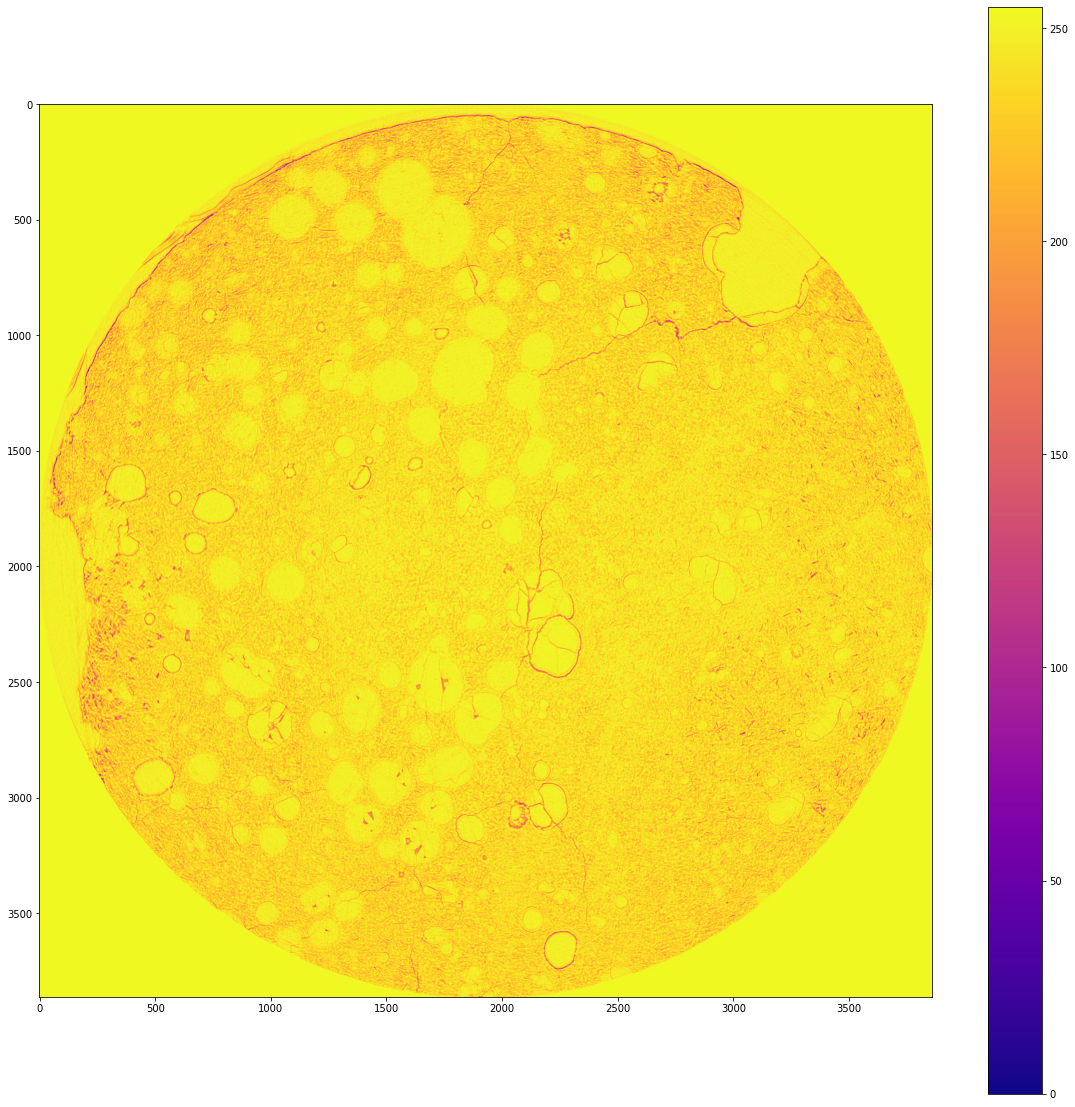

In [4]:
helpers.plot_image(helpers.fix_brightness(img))

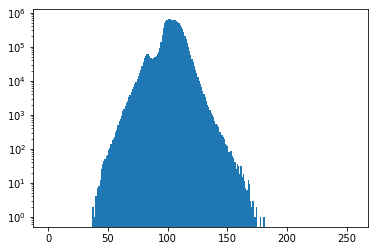

In [72]:
fig, ax = plt.subplots()
# i = helpers.fix_brightness(img)
i = helpers.remove_data_based_on_radius(img, -1)

ax.hist(i.ravel(), bins=np.linspace(0, 255, 256))
ax.set_yscale('log')

array([[-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       ...,
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.],
       [-1., -1., -1., ..., -1., -1., -1.]])

array([0, 1], dtype=uint8)

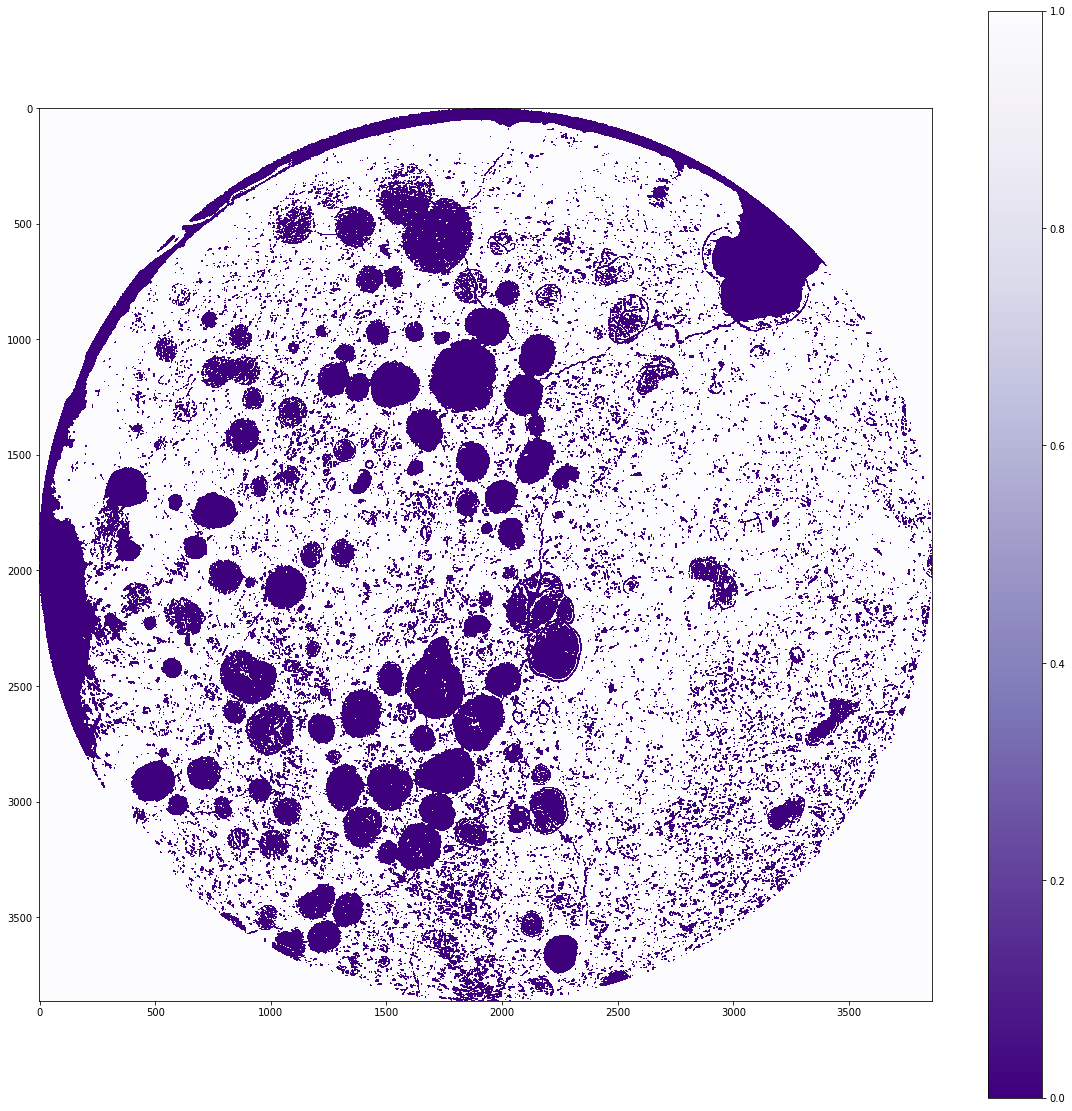

In [73]:
# global thresholding
# ret1,th1 = cv2.threshold(img,127,255,cv2.THRESH_BINARY)

# Otsu's thresholding
# ret3,th3 = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
i = img.copy()
# i = helpers.fix_brightness(i)
# print(np.unique(i))
# i = abs(i - 255)

i = cv2.GaussianBlur(i,(5,5),0)
ret3, i = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
i = abs(i - 255)

# i = cv2.GaussianBlur(i , (5,5), 0)
# ret3, i = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

i = cv2.erode(i, np.ones((3, 3), np.uint8))
# i = cv2.erode(i, np.ones((4, 4), np.uint8))

# i = cv2.dilate(i, np.ones((4, 4), np.uint8))
# i = cv2.dilate(i, np.ones((3, 3), np.uint8))
# i = cv2.dilate(i, np.ones((2, 2), np.uint8))
# i = cv2.dilate(i, np.ones((1, 1), np.uint8))
# i = cv2.erode(i, np.ones((4, 4), np.uint8))

i = cv2.GaussianBlur(i,(5,5),0)
ret3, i = cv2.threshold(i, 0, 255, cv2.THRESH_BINARY)
i = abs(i - 255)
i = cv2.erode(i, np.ones((4, 4), np.uint8))
# i = cv2.dilate(i, np.ones((3, 3), np.uint8))

# i = abs(i + 255)

helpers.plot_image(i, cmap='Purples_r', interpolation='none')
np.unique(i)

In [67]:
labeled = label(helpers.remove_data_based_on_radius(abs(i-255)))
df = regionprops_table(labeled, properties=['bbox', 'bbox_area', 'convex_area', 'eccentricity', 'extent', 'label', 'major_axis_length', 'minor_axis_length'])

In [68]:
df = pd.DataFrame(df)

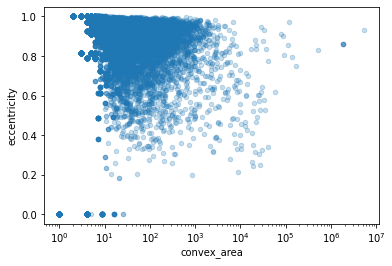

In [73]:
fig, ax = plt.subplots()
df.plot.scatter(x='convex_area', y='eccentricity', ax=ax, alpha=0.25)
ax.set_xscale('log')

(<Figure size 1440x1440 with 2 Axes>, <AxesSubplot:>)

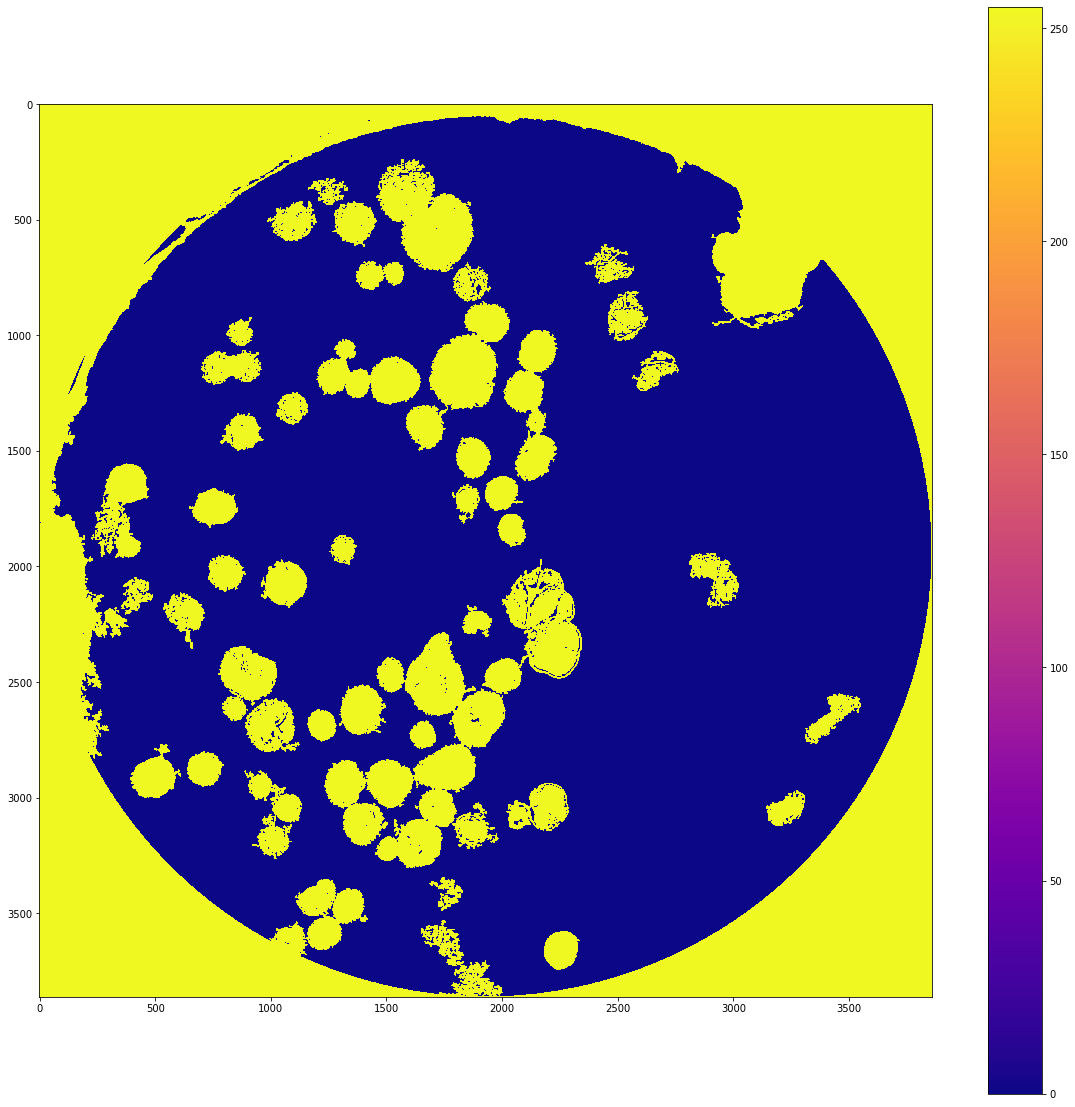

In [100]:
def convert_to_binary(img):
    ones_i = np.where(np.isnan(img), 0, 255).astype(np.uint8)
    return ones_i

imgconvex = np.where(np.isin(labeled, df[df.convex_area > 10000].label.values), labeled, np.nan)
imgconvex = convert_to_binary(imgconvex)


imgconvex = cv2.dilate(imgconvex, np.ones((5, 5), np.uint8))
# imgconvex = cv2.dilate(imgconvex, np.ones((7, 7), np.uint8))
# imgconvex = cv2.dilate(imgconvex, np.ones((7, 7), np.uint8))
helpers.plot_image(imgconvex, interpolation='none')
# np.unique(imgconvex)